In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm # Torch Image Classifier

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.26.4
Pandas version 2.2.2


In [10]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [11]:
data_dir = "/kaggle/input/cards-image-datasetclassification/train"
target_to_class = {v:k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(
    data_dir = data_dir, transform = transform
)

In [13]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [14]:
for images, label in dataloader:
    break

In [15]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        
        self.classifier = nn.Linear(enet_out_size, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = SimpleCardClassifier(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [17]:
# Testing the model
example_out = model(images)
example_out.shape    # [batch_size, num_classes]

torch.Size([32, 53])

In [18]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
criterion(example_out, label)

tensor(4.0062, grad_fn=<NllLossBackward0>)

In [20]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = "/kaggle/input/cards-image-datasetclassification/train"
valid_folder = "/kaggle/input/cards-image-datasetclassification/valid"
test_folder = "/kaggle/input/cards-image-datasetclassification/test"

train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
num_epochs = 10

train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Set the model to train
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    # Validation Phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_dataloader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_dataloader.dataset)
    val_losses.append(val_loss)
    
    # print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.5781370137445825, Validation loss: 0.3883966752943003


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.5411015779624331, Validation loss: 0.2215240403728665


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.3300596840624919, Validation loss: 0.1535666601837806


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.2291205584424365, Validation loss: 0.18126810570862495


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.18844059318429152, Validation loss: 0.22565973403881182


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.1521692796877086, Validation loss: 0.16000195920889107


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.15477401118213457, Validation loss: 0.16202498696885018


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.14209554583060965, Validation loss: 0.25466126299129344


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.12193363885603384, Validation loss: 0.130748725169391


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.09061787257915029, Validation loss: 0.12028200890658036


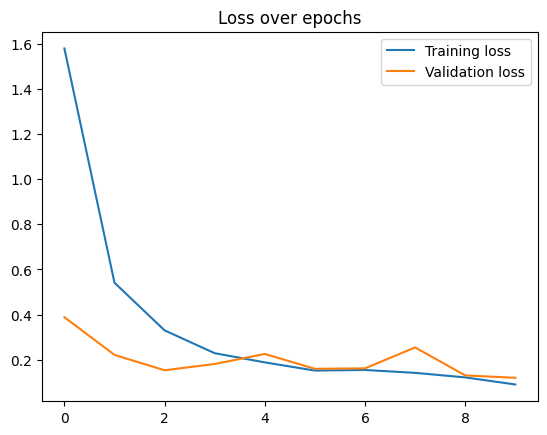

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

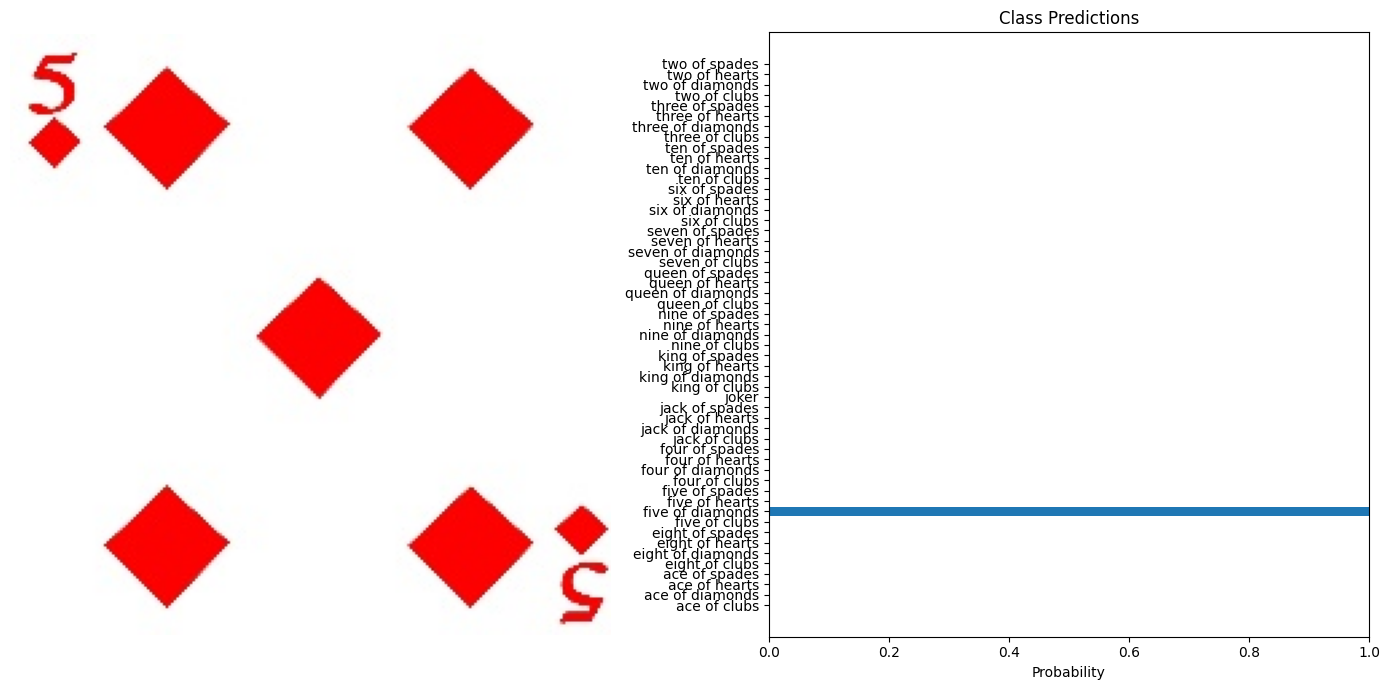

In [24]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

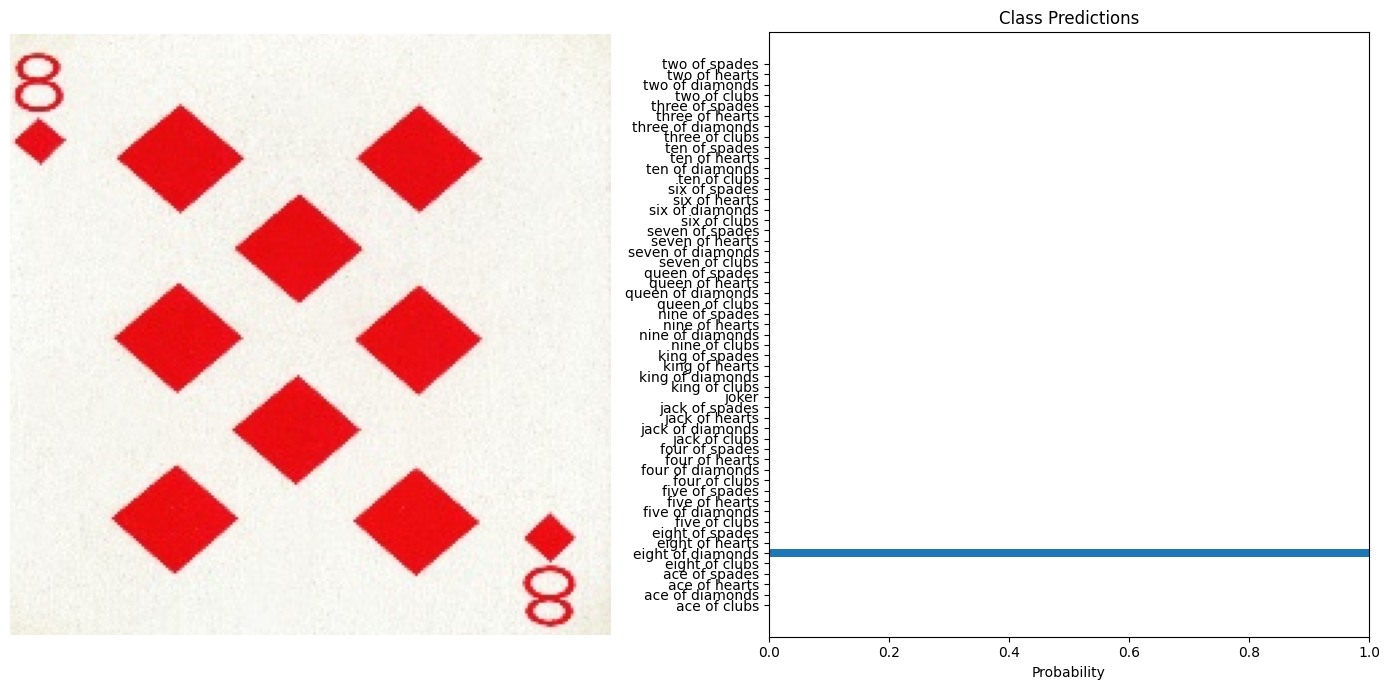

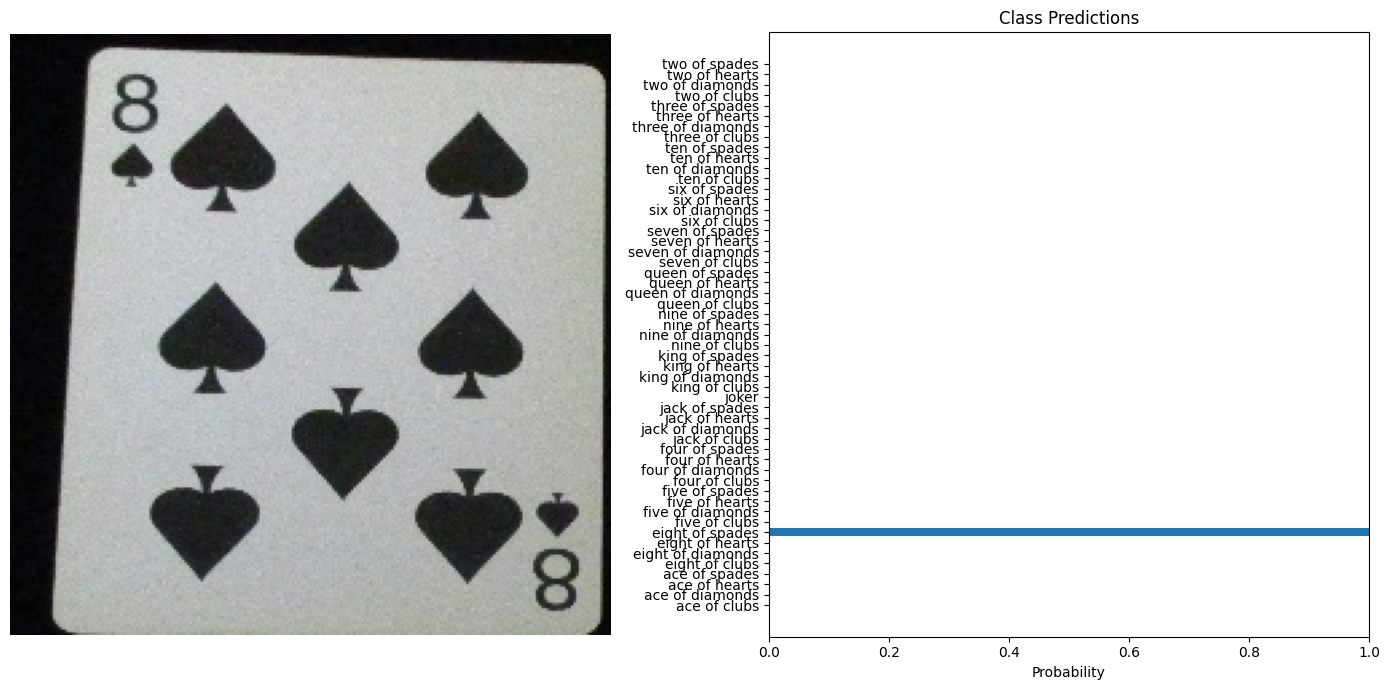

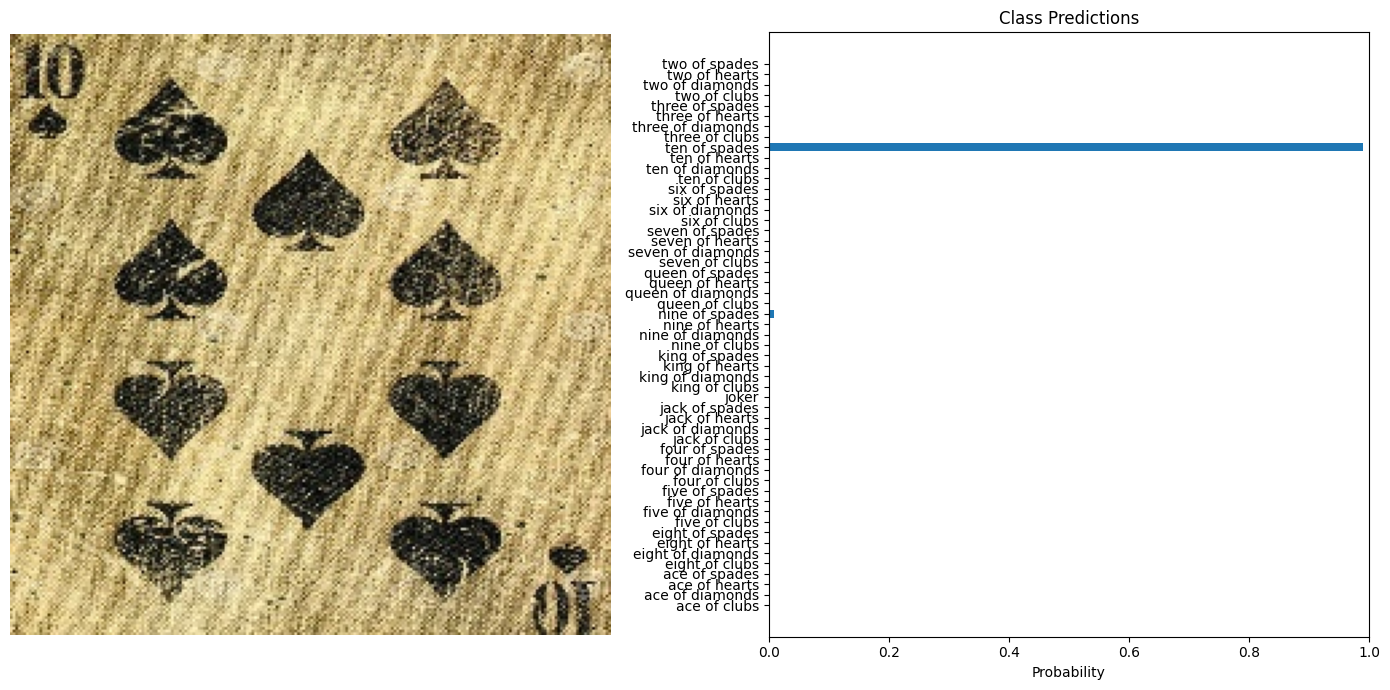

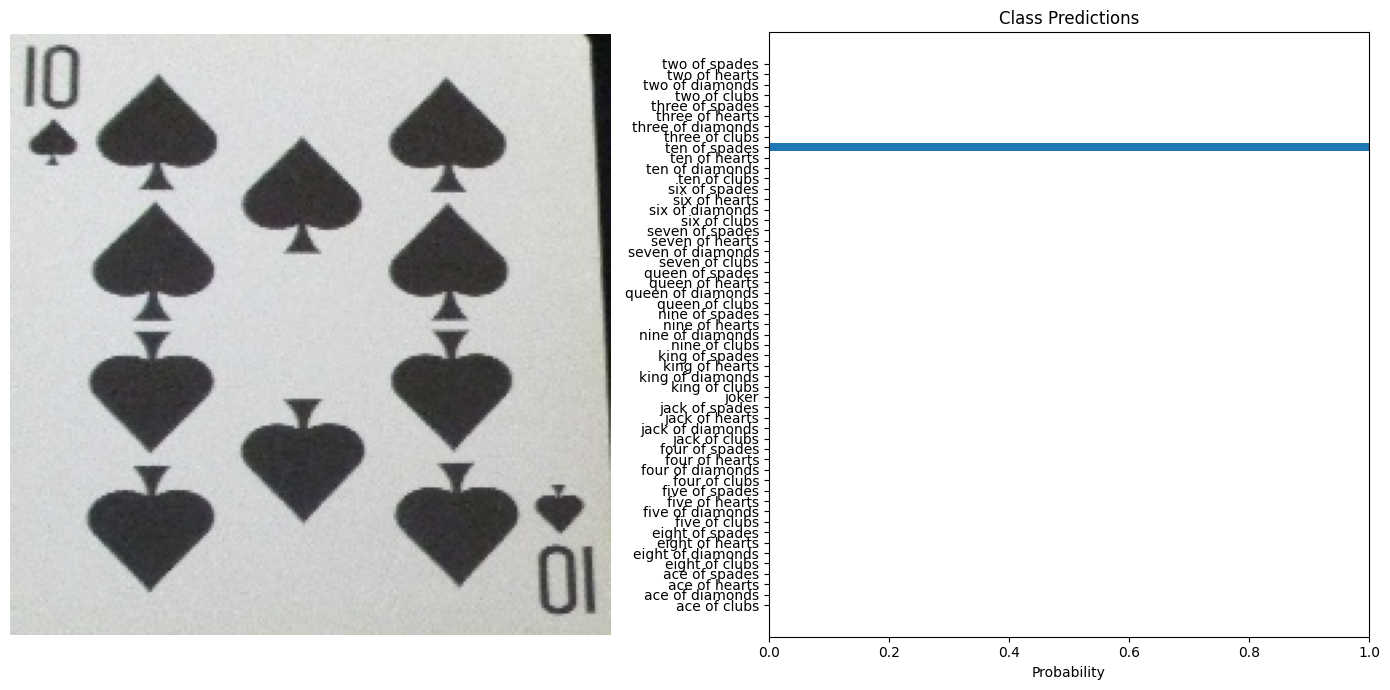

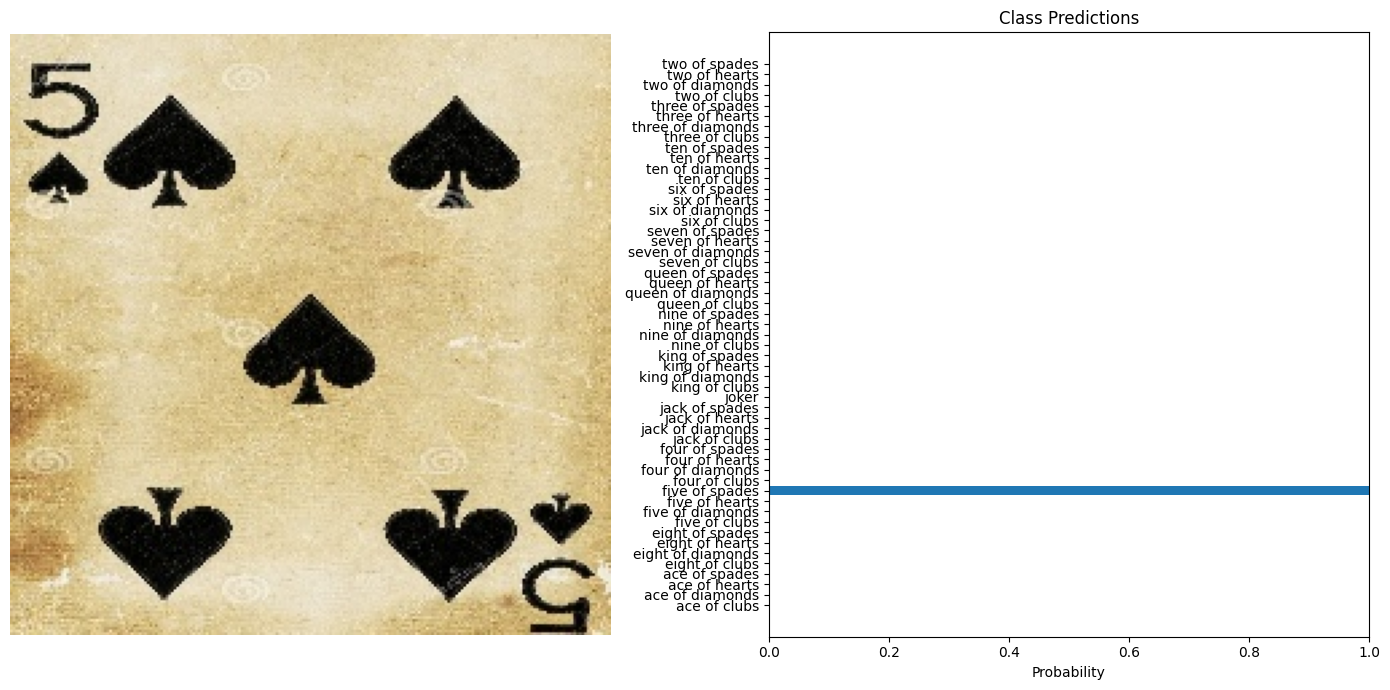

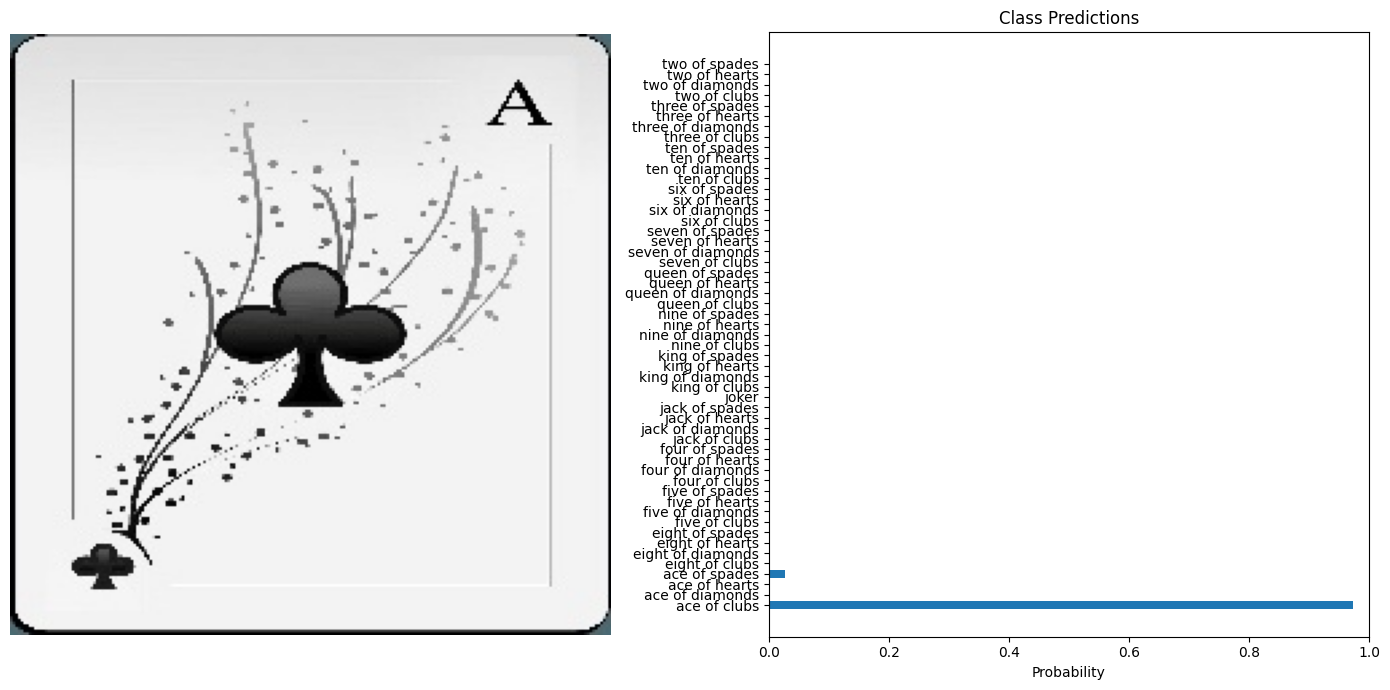

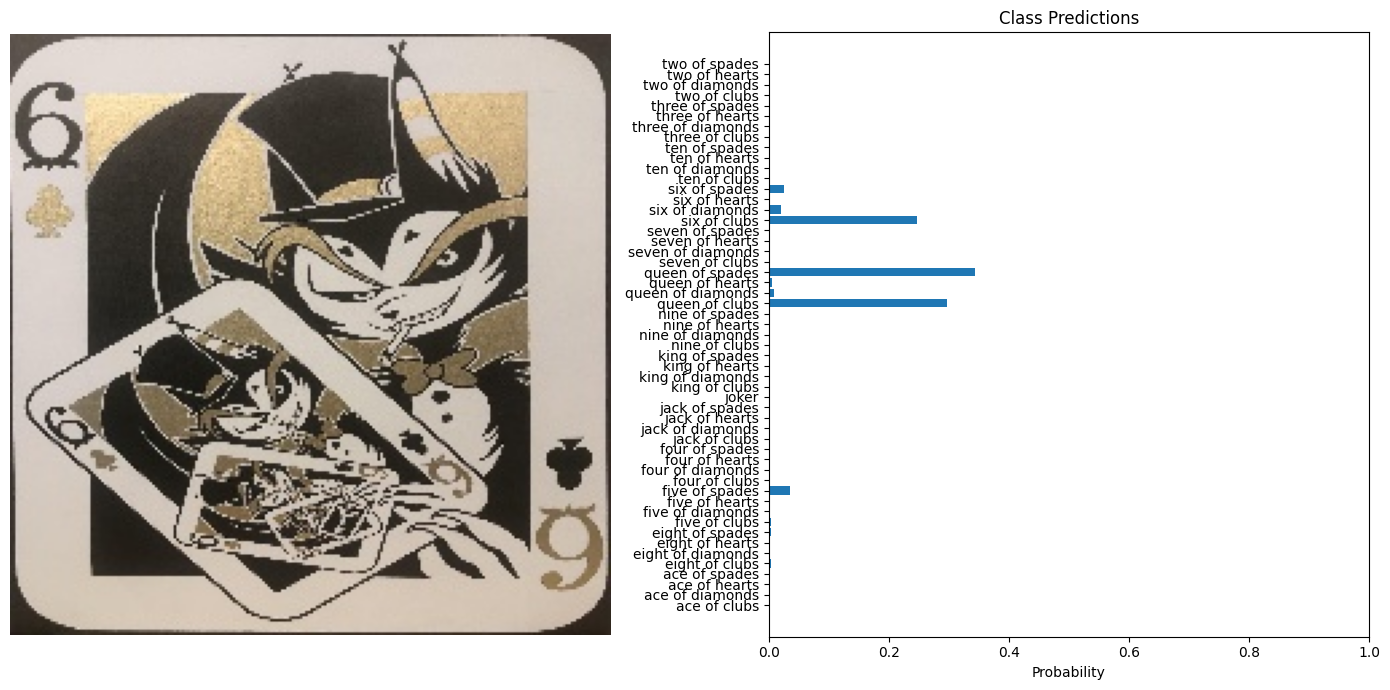

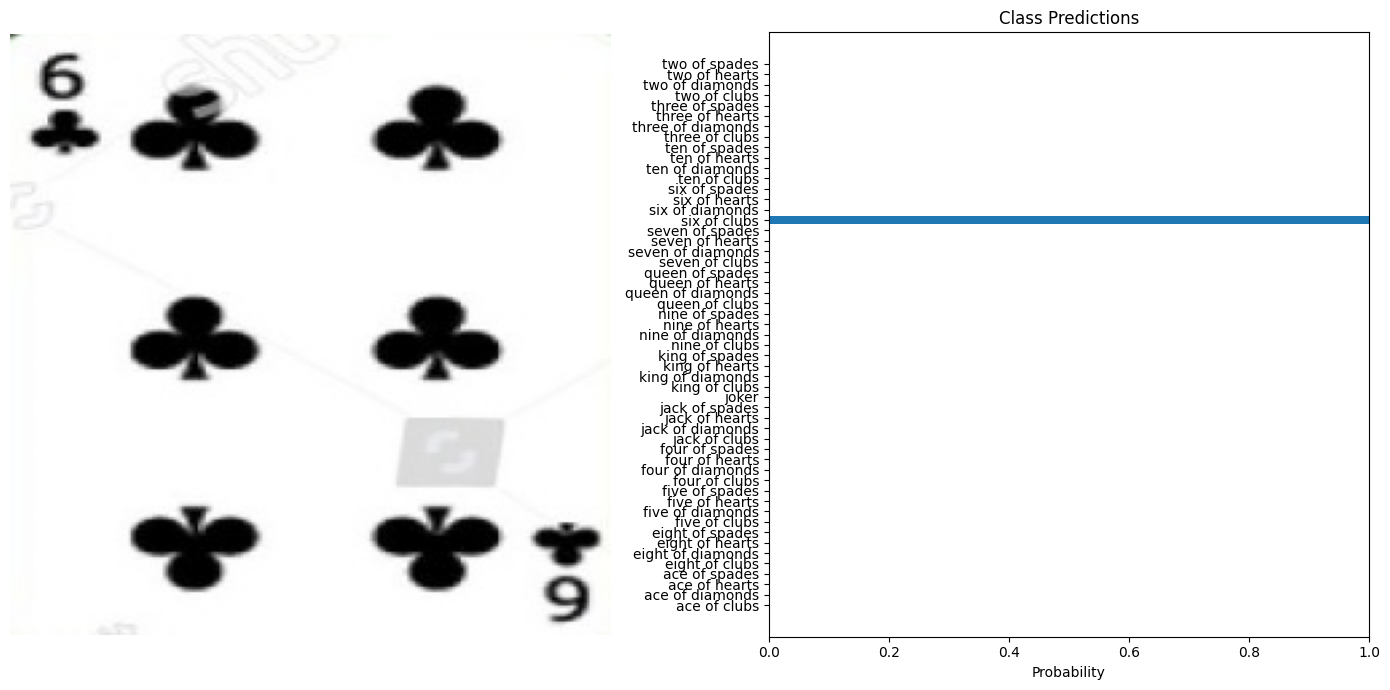

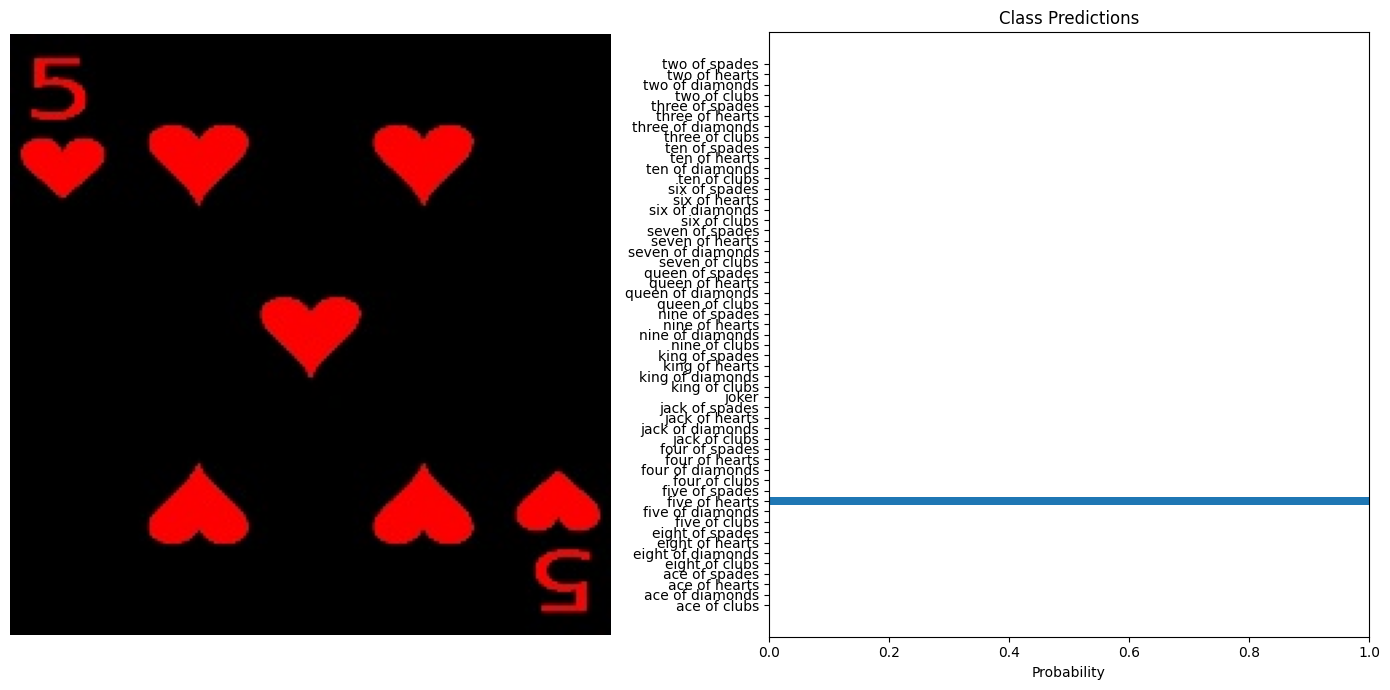

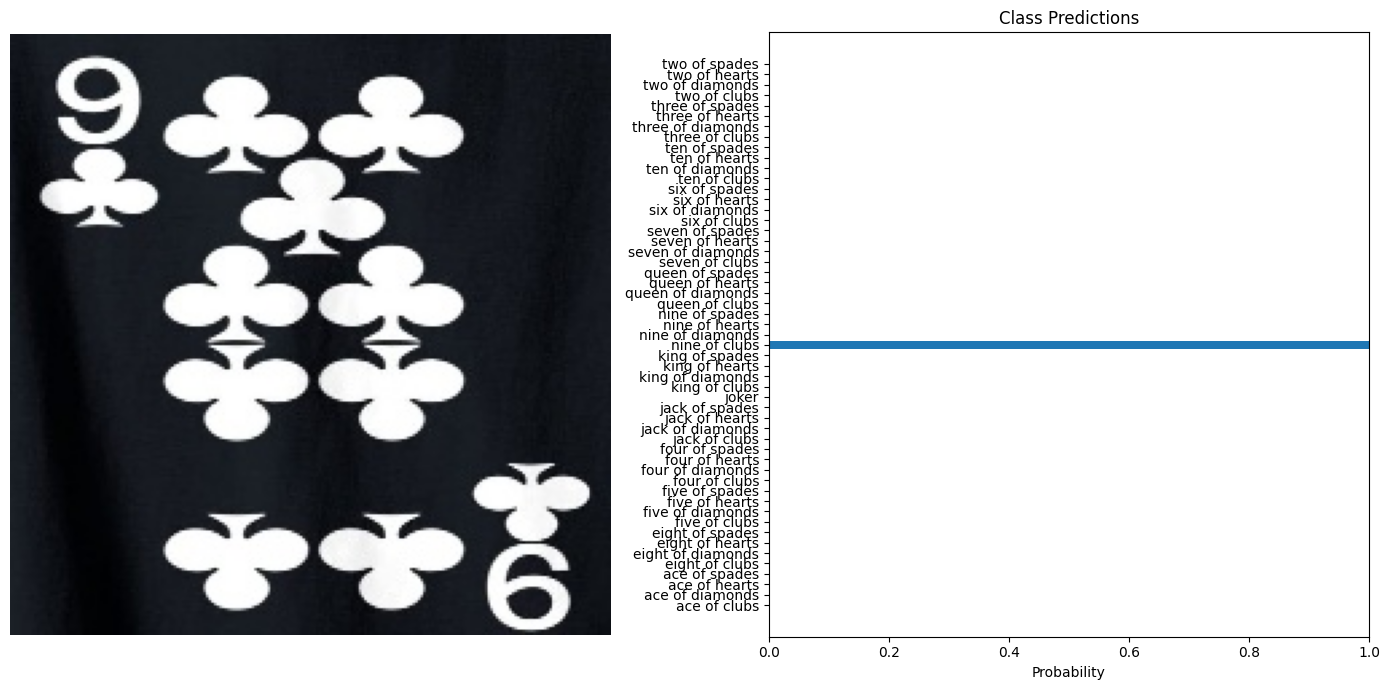

In [25]:
from glob import glob

test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_example = np.random.choice(test_images,10)

for example in test_example:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)
    
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)

In [26]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# After training, calculate accuracy on the test set

test_accuracy = calculate_accuracy(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 98.11320754716981%
